In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from pyomo import environ as pe
from global_sets.component import m

# from physics.kinetics_bounded import kinetic_block_rule
# from physics.energy_bounded import energy_block_rule
# from physics.VLE_bounded import VLE_block_rule

from stages.reactive_stage import reactive_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF

model = pe.ConcreteModel()

In [3]:
model.TRAY = pe.RangeSet(1,1)

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].H_F
| reactive[1].T
| reactive[1].T_F
| reactive[1].P
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].r_total_comp
| reactive[1].PR_L
| reactive[1].PR_V
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_b

In [5]:
model.reactive[model.TRAY.last()].V['in'].fix(0)
model.reactive[model.TRAY.first()].L['in'].fix(0)
for i in m.COMP_TOTAL:
    model.reactive[model.TRAY.last()].y_['in',i].fix(0)
    model.reactive[model.TRAY.first()].x_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)
model.reactive[model.TRAY.first()].H_L_['in'].fix(0)

In [6]:
check_DOF(pe,model)

Active Equality Constraints:	 1184
Active Inequality Constraints:	 1
Active Variables:		 1360
Fixed Variables:		 162
DOF:				 14


In [7]:
for j in model.reactive:
    model.reactive[j].cat.fix(3000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(20)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(1/(1+0.8)-0.01/2)
    model.reactive[j].z['H2'].fix(0.8/(1+0.8)-0.01/2)
    model.reactive[j].z['C30H62'].fix(0.01)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    model.reactive[j].T.setub(300+273.15)
#     model.reactive[j].Q_main.fix(0)

In [8]:
check_DOF(pe,model)

Active Equality Constraints:	 1184
Active Inequality Constraints:	 1
Active Variables:		 1360
Fixed Variables:		 172
DOF:				 4


In [9]:
model.obj = pe.Objective(expr=model.reactive[1].T, sense=pe.maximize)
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'

opt.options['max_iter'] = 7000
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [10]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.11.1: print_user_options=yes
max_iter=7000


List of user-set options:

                                    Name   Value                used
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     4017
Number of nonzeros in inequality constraint Jacob

  81 -5.2937970e+002 5.06e+000 4.39e+009  -2.5 3.79e+004    -  1.20e-002 1.56e-003h  1
  82 -5.3026100e+002 4.51e+000 3.58e+009  -2.5 3.73e+004    -  1.35e-001 1.74e-001h  1
  83 -5.3027007e+002 4.51e+000 3.57e+009  -2.5 4.12e+004    -  1.25e-002 1.90e-003h  1
  84 -5.3117341e+002 4.05e+000 2.81e+009  -2.5 4.09e+004    -  1.22e-001 1.80e-001f  1
  85 -5.3118401e+002 4.04e+000 2.81e+009  -2.5 4.42e+004    -  1.73e-002 2.24e-003h  1
  86 -5.3208293e+002 3.66e+000 2.18e+009  -2.5 4.40e+004    -  1.25e-001 1.81e-001f  1
  87 -5.3209361e+002 3.65e+000 2.17e+009  -2.5 4.74e+004    -  2.12e-002 2.32e-003h  1
  88 -5.3299144e+002 3.33e+000 1.67e+009  -2.5 4.73e+004    -  1.26e-001 1.83e-001f  1
  89 -5.3300481e+002 3.32e+000 1.66e+009  -2.5 5.04e+004    -  2.45e-002 3.00e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -5.3391246e+002 3.06e+000 1.27e+009  -2.5 5.04e+004    -  1.25e-001 1.87e-001f  1
  91 -5.3393532e+002 3.05e+000 1.26e+009  -2.5 5.

Dual infeasibility......:  2.8144153674247718e-014   2.8144153674247718e-014
Constraint violation....:  1.5274217350993990e-010   1.5274217350993990e-010
Complementarity.........:  2.5059035597116733e-009   2.5059035597116733e-009
Overall NLP error.......:  2.5059035597116733e-009   2.5059035597116733e-009


Number of objective function evaluations             = 239
Number of objective gradient evaluations             = 147
Number of equality constraint evaluations            = 239
Number of inequality constraint evaluations          = 239
Number of equality constraint Jacobian evaluations   = 174
Number of inequality constraint Jacobian evaluations = 174
Number of Lagrangian Hessian evaluations             = 166
Total CPU secs in IPOPT (w/o function evaluations)   =      1.249
Total CPU secs in NLP function evaluations           =      0.069

EXIT: Optimal Solution Found.


In [11]:
print(model.reactive[1].T.value)

573.15


In [12]:
print(model.reactive[1].Q_main.value)

-55.309564890060024


In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
rf_data = {}
rf_data['T'] = []
rf_data['dH_V_CO'] = []; rf_data['dH_V_H2'] = []; rf_data['dH_V_CO2'] = []; rf_data['dH_V_H2O'] = []; rf_data['dH_V_C6H12'] = []; 
rf_data['dH_L_CO'] = []; rf_data['dH_L_H2'] = []; rf_data['dH_L_CO2'] = []; rf_data['dH_L_H2O'] = []; rf_data['dH_L_C6H12'] = [];
rf_data['dH_vap_CO'] = []; rf_data['dH_vap_H2'] = []; rf_data['dH_vap_CO2'] = []; rf_data['dH_vap_H2O'] = []; rf_data['dH_vap_C6H12'] = [];

rf_data['k_FT'] = []; rf_data['g0_FT'] = []; rf_data['alpha'] = []; rf_data['k_WGS'] = []; rf_data['Ke_WGS'] = [];

rf_data['Hen_CO'] = []; rf_data['Hen_H2'] = []; rf_data['Hen_CO2'] = []; rf_data['Hen_H2O'] = []; rf_data['Hen_C2H4'] = [];
rf_data['Hen0_CO'] = []; rf_data['Hen0_H2'] = []; rf_data['Hen0_CO2'] = []; rf_data['Hen0_H2O'] = []; rf_data['Hen0_C2H4'] = [];
rf_data['gamma_C4H10'] = []; rf_data['gamma_C6H14'] = []; rf_data['gamma_C12H24'] = []; 
rf_data['P_sat_C4H10'] = []; rf_data['P_sat_C6H14'] = []; rf_data['P_sat_C12H24'] = []; 
rf_data['P_sat_Y_C4H10'] = []; rf_data['P_sat_Y_C6H14'] = []; rf_data['P_sat_Y_C12H24'] = []; 
rf_data['P_sat_dY0'] = []; rf_data['P_sat_dY_inf'] = []; rf_data['Hen_ref'] = []; rf_data['Hen0_ref'] = []; rf_data['gamma_ref'] = [];

Trange = np.arange(300+273.15, 200+273.15, -2)

for Tub in Trange:
    model.reactive[1].T.setub(Tub)
    results = opt.solve(model, tee=False)
    update_dual(pe,model)
    print('Solved, Solution T = {} K'.format(model.reactive[1].T.value))

    # ==========Energy Block=======================================================
    rf_data['T'].append(model.reactive[1].T.value)
    rf_data['dH_V_CO'].append(model.reactive[1].energy_block.dH_V['CO'].value)
    rf_data['dH_V_H2'].append(model.reactive[1].energy_block.dH_V['H2'].value)
    rf_data['dH_V_CO2'].append(model.reactive[1].energy_block.dH_V['CO2'].value)
    rf_data['dH_V_H2O'].append(model.reactive[1].energy_block.dH_V['H2O'].value)
    rf_data['dH_V_C6H12'].append(model.reactive[1].energy_block.dH_V['C6H12'].value)
    
    rf_data['dH_L_CO'].append(model.reactive[1].energy_block.dH_L['CO'].value)
    rf_data['dH_L_H2'].append(model.reactive[1].energy_block.dH_L['H2'].value)
    rf_data['dH_L_CO2'].append(model.reactive[1].energy_block.dH_L['CO2'].value)
    rf_data['dH_L_H2O'].append(model.reactive[1].energy_block.dH_L['H2O'].value)
    rf_data['dH_L_C6H12'].append(model.reactive[1].energy_block.dH_L['C6H12'].value)
    
    rf_data['dH_vap_CO'].append(model.reactive[1].energy_block.dH_vap['CO'].value)
    rf_data['dH_vap_H2'].append(model.reactive[1].energy_block.dH_vap['H2'].value)
    rf_data['dH_vap_CO2'].append(model.reactive[1].energy_block.dH_vap['CO2'].value)
    rf_data['dH_vap_H2O'].append(model.reactive[1].energy_block.dH_vap['H2O'].value)
    rf_data['dH_vap_C6H12'].append(model.reactive[1].energy_block.dH_vap['C6H12'].value)
    
    # ==========Kinetics Block=======================================================
    rf_data['k_FT'].append(model.reactive[1].kinetics_block.k_FT.value)
    rf_data['g0_FT'].append(model.reactive[1].kinetics_block.g0_FT.value)
    rf_data['alpha'].append(model.reactive[1].kinetics_block.alpha.value)
    rf_data['k_WGS'].append(model.reactive[1].kinetics_block.k_WGS.value)
    rf_data['Ke_WGS'].append(model.reactive[1].kinetics_block.Ke_WGS.value)

    # ==========VLE Block=============================================================
    rf_data['Hen_CO'].append(model.reactive[1].VLE_block.Hen['CO'].value)
    rf_data['Hen_H2'].append(model.reactive[1].VLE_block.Hen['H2'].value)
    rf_data['Hen_CO2'].append(model.reactive[1].VLE_block.Hen['CO2'].value)
    rf_data['Hen_H2O'].append(model.reactive[1].VLE_block.Hen['H2O'].value)
    rf_data['Hen_C2H4'].append(model.reactive[1].VLE_block.Hen['C2H4'].value)
    
    rf_data['Hen0_CO'].append(model.reactive[1].VLE_block.Hen0['CO'].value)
    rf_data['Hen0_H2'].append(model.reactive[1].VLE_block.Hen0['H2'].value)
    rf_data['Hen0_CO2'].append(model.reactive[1].VLE_block.Hen0['CO2'].value)
    rf_data['Hen0_H2O'].append(model.reactive[1].VLE_block.Hen0['H2O'].value)
    rf_data['Hen0_C2H4'].append(model.reactive[1].VLE_block.Hen0['C2H4'].value)
    
    rf_data['gamma_C4H10'].append(model.reactive[1].VLE_block.gamma['C4H10'].value)
    rf_data['gamma_C6H14'].append(model.reactive[1].VLE_block.gamma['C6H14'].value)
    rf_data['gamma_C12H24'].append(model.reactive[1].VLE_block.gamma['C12H24'].value)
    
    rf_data['P_sat_C4H10'].append(model.reactive[1].VLE_block.P_sat['C4H10'].value)
    rf_data['P_sat_C6H14'].append(model.reactive[1].VLE_block.P_sat['C6H14'].value)
    rf_data['P_sat_C12H24'].append(model.reactive[1].VLE_block.P_sat['C12H24'].value)
    
    rf_data['P_sat_Y_C4H10'].append(model.reactive[1].VLE_block.P_sat_Y['C4H10'].value)
    rf_data['P_sat_Y_C6H14'].append(model.reactive[1].VLE_block.P_sat_Y['C6H14'].value)
    rf_data['P_sat_Y_C12H24'].append(model.reactive[1].VLE_block.P_sat_Y['C12H24'].value)
    
    rf_data['P_sat_dY0'].append(model.reactive[1].VLE_block.P_sat_dY0.value)
    rf_data['P_sat_dY_inf'].append(model.reactive[1].VLE_block.P_sat_dY_inf.value)
    rf_data['Hen_ref'].append(model.reactive[1].VLE_block.Hen_ref.value)
    rf_data['Hen0_ref'].append(model.reactive[1].VLE_block.Hen0_ref.value)
    rf_data['gamma_ref'].append(model.reactive[1].VLE_block.gamma_ref.value)

Solved, Solution T = 573.15 K
Solved, Solution T = 571.15 K
Solved, Solution T = 569.15 K
Solved, Solution T = 567.15 K
Solved, Solution T = 565.15 K
Solved, Solution T = 563.15 K
Solved, Solution T = 561.15 K
Solved, Solution T = 559.15 K
Solved, Solution T = 557.15 K
Solved, Solution T = 555.15 K
Solved, Solution T = 553.15 K
Solved, Solution T = 551.15 K
Solved, Solution T = 549.15 K
Solved, Solution T = 547.15 K
Solved, Solution T = 545.15 K
Solved, Solution T = 543.15 K
Solved, Solution T = 541.15 K
Solved, Solution T = 539.15 K
Solved, Solution T = 537.15 K
Solved, Solution T = 535.15 K
Solved, Solution T = 533.15 K
Solved, Solution T = 531.15 K
Solved, Solution T = 529.15 K
Solved, Solution T = 527.15 K
Solved, Solution T = 525.15 K
Solved, Solution T = 523.15 K
Solved, Solution T = 521.15 K
Solved, Solution T = 519.15 K
Solved, Solution T = 517.15 K
Solved, Solution T = 515.15 K
Solved, Solution T = 513.15 K
Solved, Solution T = 511.15 K
Solved, Solution T = 509.15 K
Solved, So

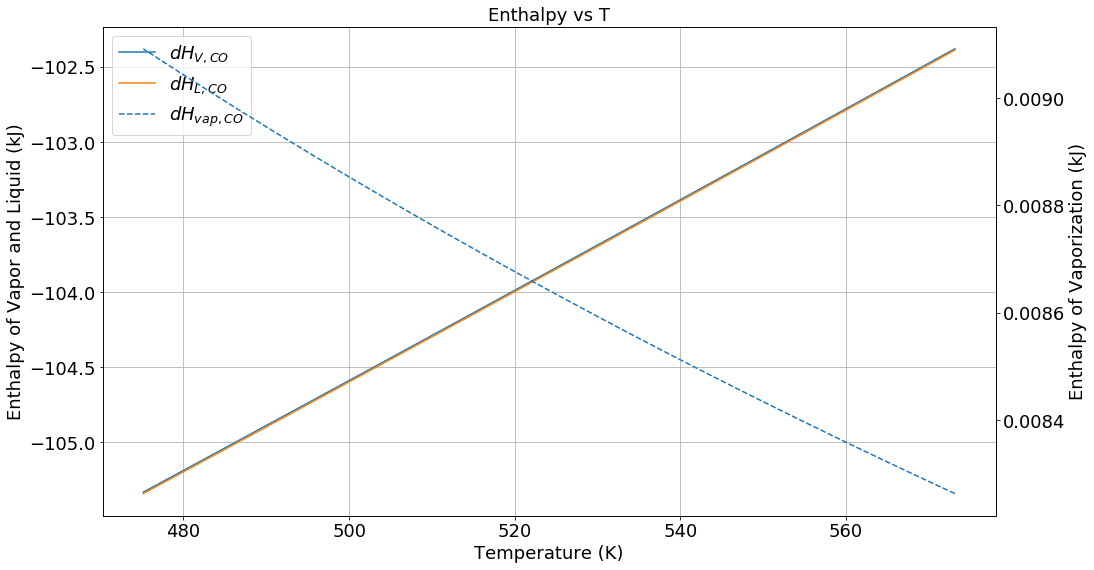

In [15]:
fig, ax1 = plt.subplots(figsize=(16,9))
# ax.plot(rf_data['T'],rf_data['dH_V_CO'])
# ax.plot(rf_data['T'],rf_data['dH_V_H2'])
# ax.plot(rf_data['T'],rf_data['dH_V_CO2'])
# ax.plot(rf_data['T'],rf_data['dH_V_H2O'])
# ax.plot(rf_data['T'],rf_data['dH_V_C6H12'])

line1 = ax1.plot(rf_data['T'],rf_data['dH_V_CO'])
line2 = ax1.plot(rf_data['T'],rf_data['dH_L_CO'])
ax1.set_ylabel('Enthalpy of Vapor and Liquid (kJ)', color='K',fontsize=18)
ax1.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax1.tick_params('y', colors='k',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line3 = ax2.plot(rf_data['T'],rf_data['dH_vap_CO'],'--')
ax2.set_ylabel('Enthalpy of Vaporization (kJ)', color='K',fontsize=18)
ax2.tick_params('y', colors='k',labelsize=18)

ax1.legend(line1+line2+line3,['$dH_{V,CO}$','$dH_{L,CO}$','$dH_{vap,CO}$'],fontsize=18)
ax1.set_title('Enthalpy vs T',fontsize=18)
plt.show()

# ax.plot(rf_data['T'],rf_data['H_L'])
# ax.plot(rf_data['T'],rf_data['H_F'])

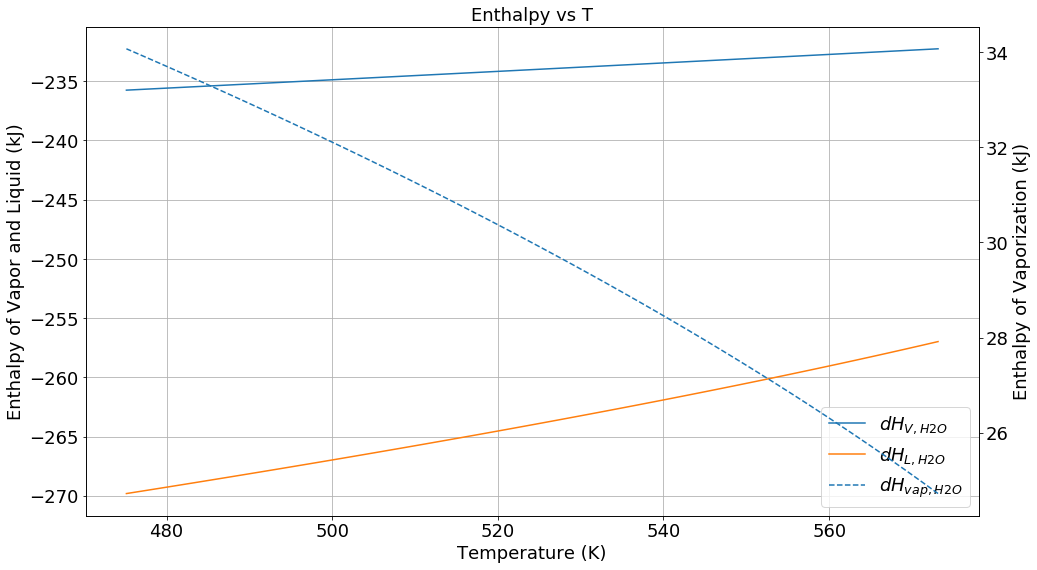

In [16]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['dH_V_H2O'])
line2 = ax1.plot(rf_data['T'],rf_data['dH_L_H2O'])
ax1.set_ylabel('Enthalpy of Vapor and Liquid (kJ)', color='K',fontsize=18)
ax1.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax1.tick_params('y', colors='k',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line3 = ax2.plot(rf_data['T'],rf_data['dH_vap_H2O'],'--')
ax2.set_ylabel('Enthalpy of Vaporization (kJ)', color='K',fontsize=18)
ax2.tick_params('y', colors='k',labelsize=18)

ax1.legend(line1+line2+line3,['$dH_{V,H2O}$','$dH_{L,H2O}$','$dH_{vap,H2O}$'],fontsize=18)
ax1.set_title('Enthalpy vs T',fontsize=18)
plt.show()

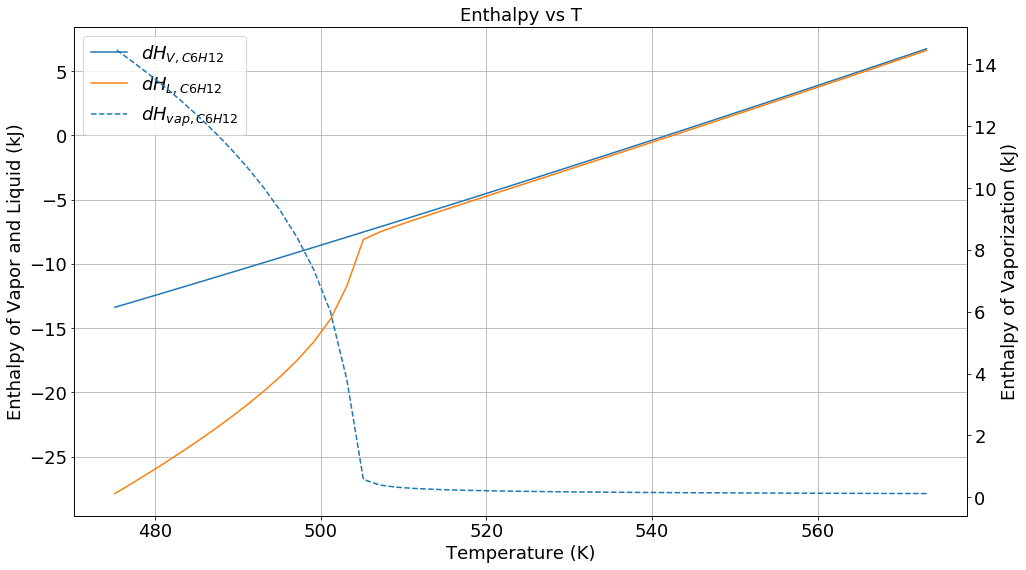

In [17]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['dH_V_C6H12'])
line2 = ax1.plot(rf_data['T'],rf_data['dH_L_C6H12'])
ax1.set_ylabel('Enthalpy of Vapor and Liquid (kJ)', color='K',fontsize=18)
ax1.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax1.tick_params('y', colors='k',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line3 = ax2.plot(rf_data['T'],rf_data['dH_vap_C6H12'], '--')
ax2.set_ylabel('Enthalpy of Vaporization (kJ)', color='K',fontsize=18)
ax2.tick_params('y', colors='k',labelsize=18)

ax1.legend(line1+line2+line3,['$dH_{V,C6H12}$','$dH_{L,C6H12}$','$dH_{vap,C6H12}$'],fontsize=18)
ax1.set_title('Enthalpy vs T',fontsize=18)
plt.show()

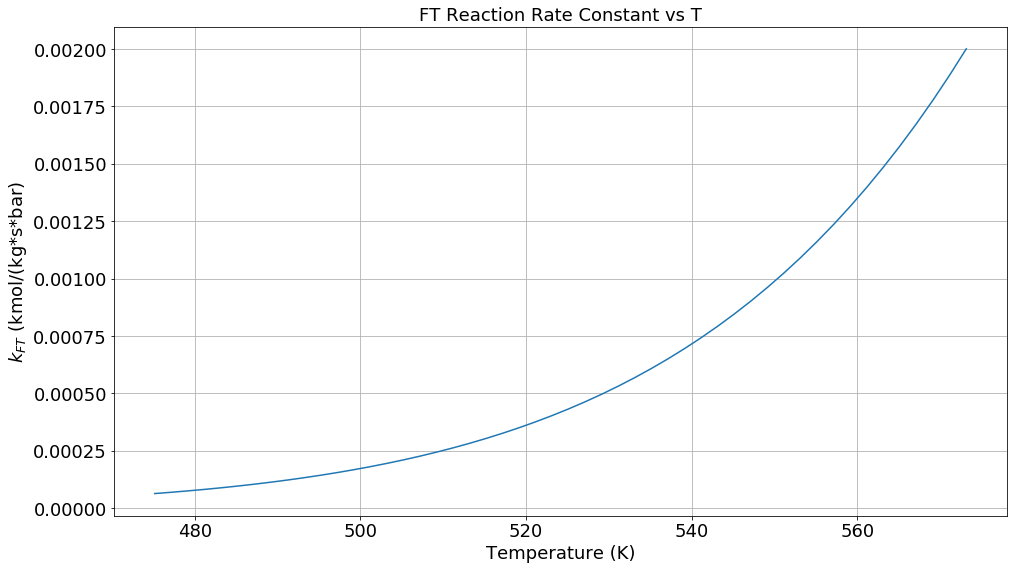

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['k_FT'])
ax.set_ylabel('$k_{FT}$ (kmol/(kg*s*bar)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('FT Reaction Rate Constant vs T',fontsize=18)
plt.show()

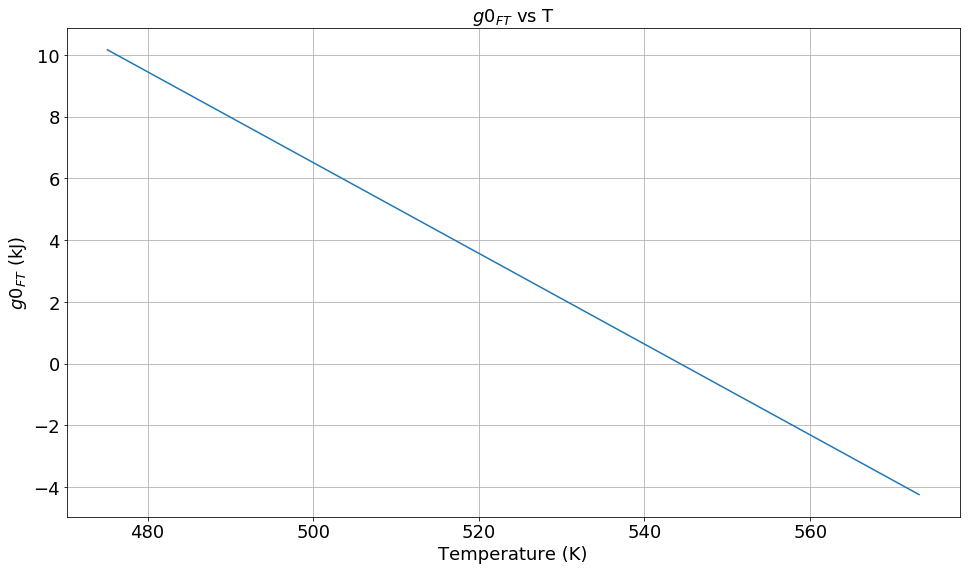

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['g0_FT'])
ax.set_ylabel('$g0_{FT}$ (kJ)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$g0_{FT}$ vs T',fontsize=18)
plt.show()

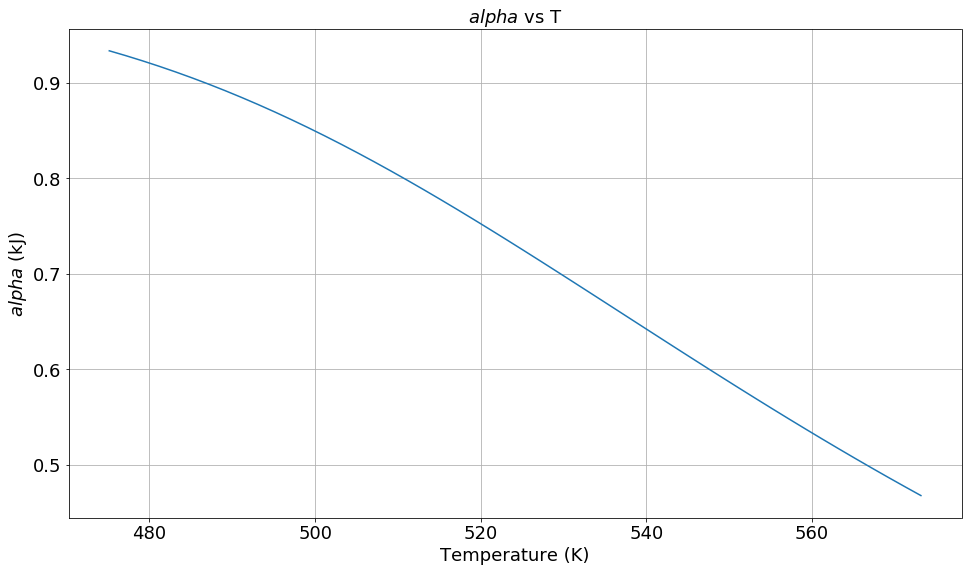

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['alpha'])
ax.set_ylabel('$alpha$ (kJ)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$alpha$ vs T',fontsize=18)
plt.show()

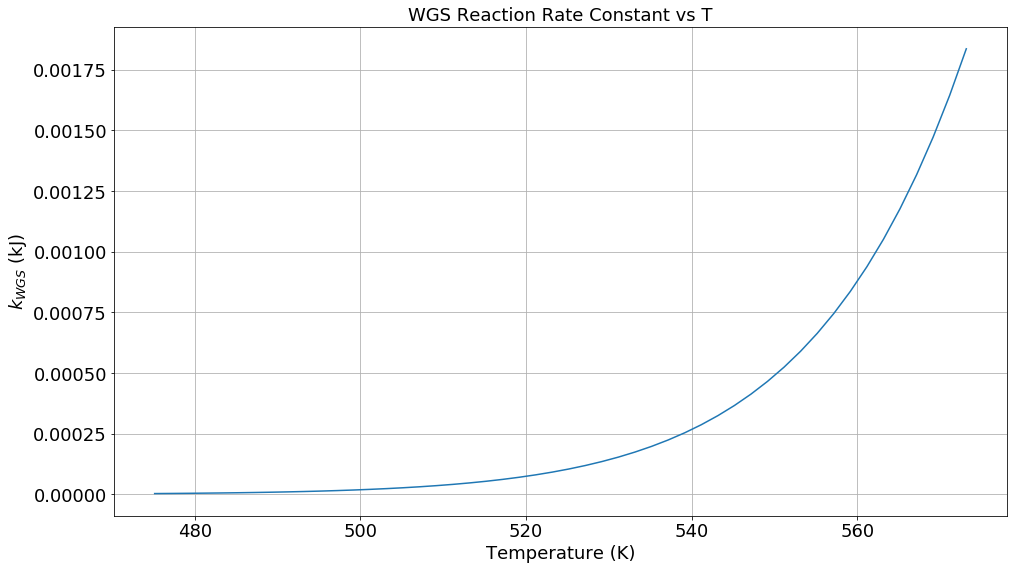

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['k_WGS'])
ax.set_ylabel('$k_{WGS}$ (kJ)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('WGS Reaction Rate Constant vs T',fontsize=18)
plt.show()

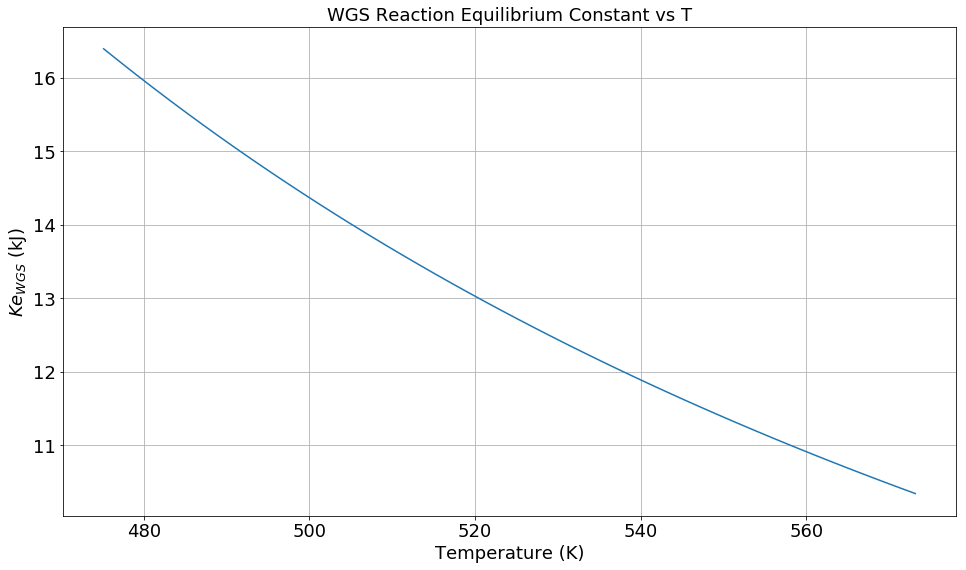

In [22]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['Ke_WGS'])
ax.set_ylabel('$Ke_{WGS}$ (kJ)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('WGS Reaction Equilibrium Constant vs T',fontsize=18)
plt.show()

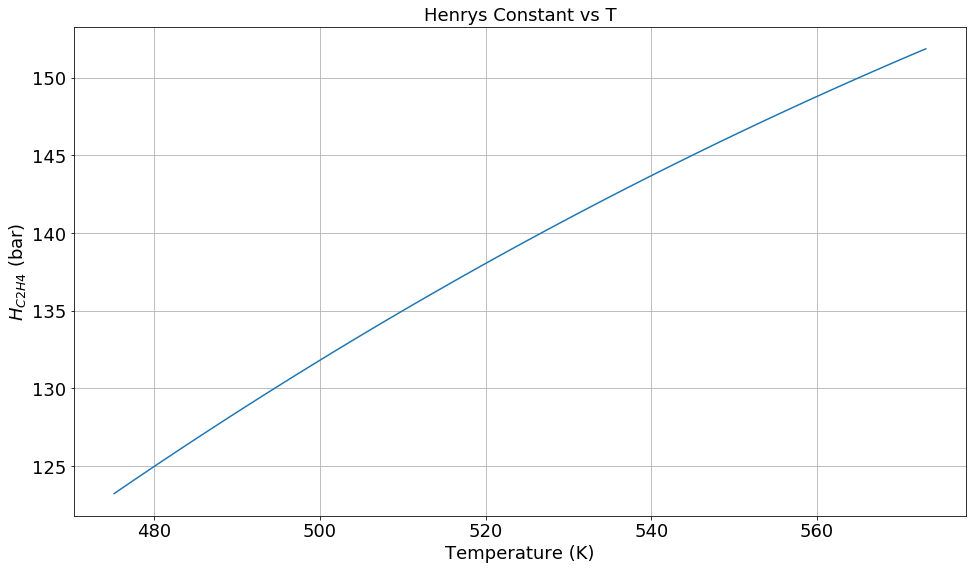

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['Hen_C2H4'])
ax.set_ylabel('$H_{C2H4}$ (bar)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('Henrys Constant vs T',fontsize=18)
plt.show()

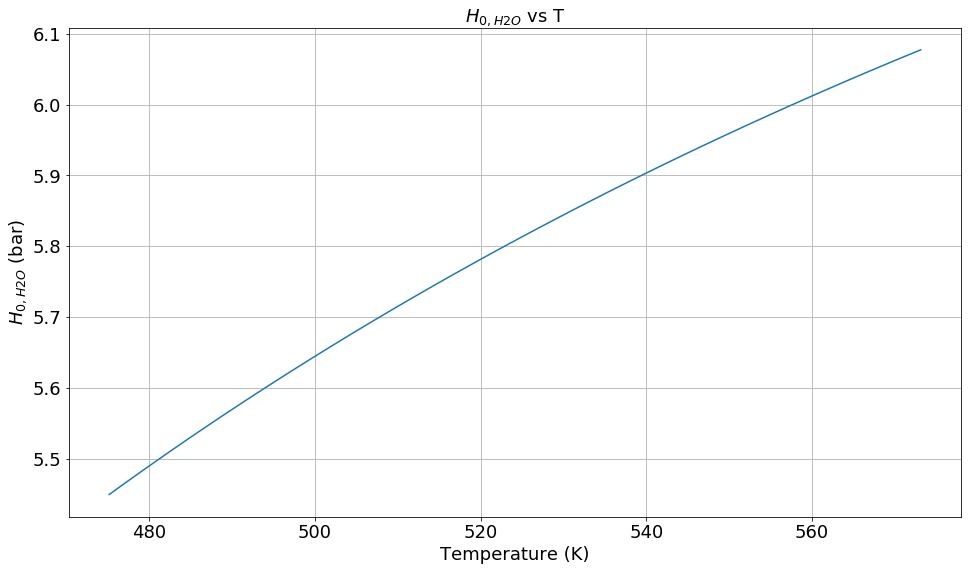

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['Hen0_H2O'])
ax.set_ylabel('$H_{0,H2O}$ (bar)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$H_{0,H2O}$ vs T',fontsize=18)
plt.show()

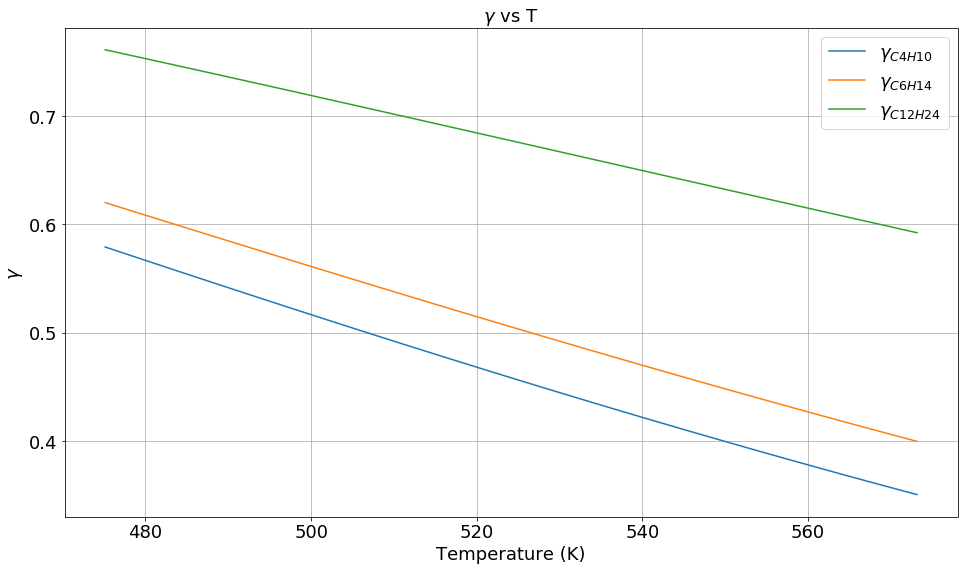

In [25]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['gamma_C4H10'])
ax.plot(rf_data['T'],rf_data['gamma_C6H14'])
ax.plot(rf_data['T'],rf_data['gamma_C12H24'])
ax.set_ylabel('$\gamma$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.legend(['$\gamma_{C4H10}$','$\gamma_{C6H14}$','$\gamma_{C12H24}$'],fontsize=18)
ax.set_title('$\gamma$ vs T',fontsize=18)
plt.show()

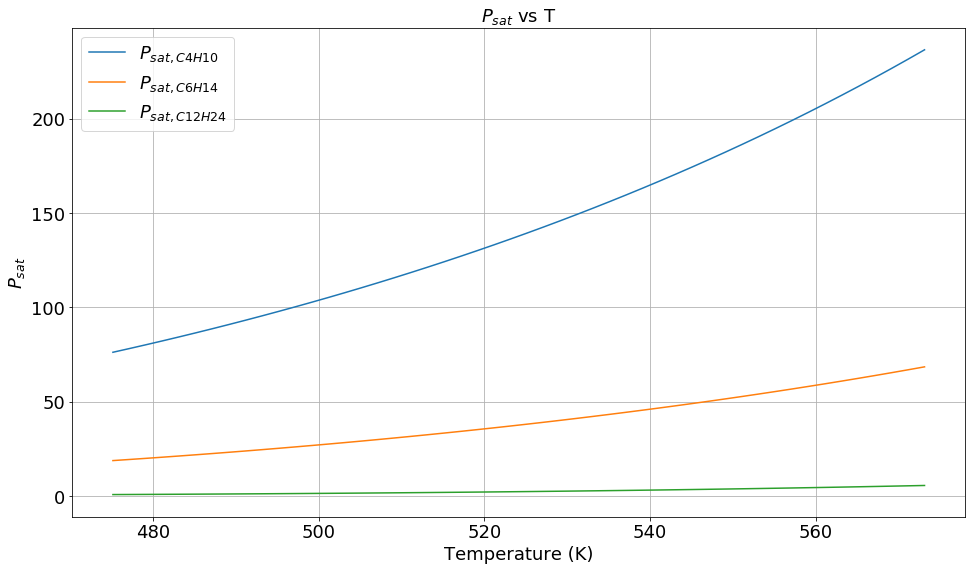

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['P_sat_C4H10'])
ax.plot(rf_data['T'],rf_data['P_sat_C6H14'])
ax.plot(rf_data['T'],rf_data['P_sat_C12H24'])
ax.set_ylabel('$P_{sat}$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.legend(['$P_{sat,C4H10}$','$P_{sat,C6H14}$','$P_{sat,C12H24}$'],fontsize=18)
ax.set_title('$P_{sat}$ vs T',fontsize=18)
plt.show()

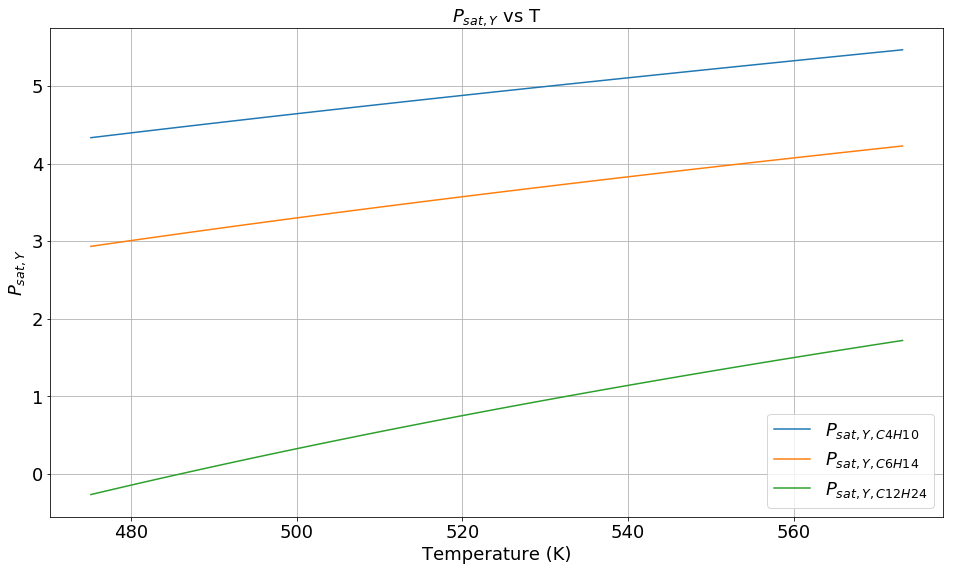

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['P_sat_Y_C4H10'])
ax.plot(rf_data['T'],rf_data['P_sat_Y_C6H14'])
ax.plot(rf_data['T'],rf_data['P_sat_Y_C12H24'])
ax.set_ylabel('$P_{sat,Y}$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.legend(['$P_{sat,Y,C4H10}$','$P_{sat,Y,C6H14}$','$P_{sat,Y,C12H24}$'],fontsize=18)
ax.set_title('$P_{sat,Y}$ vs T',fontsize=18)
plt.show()

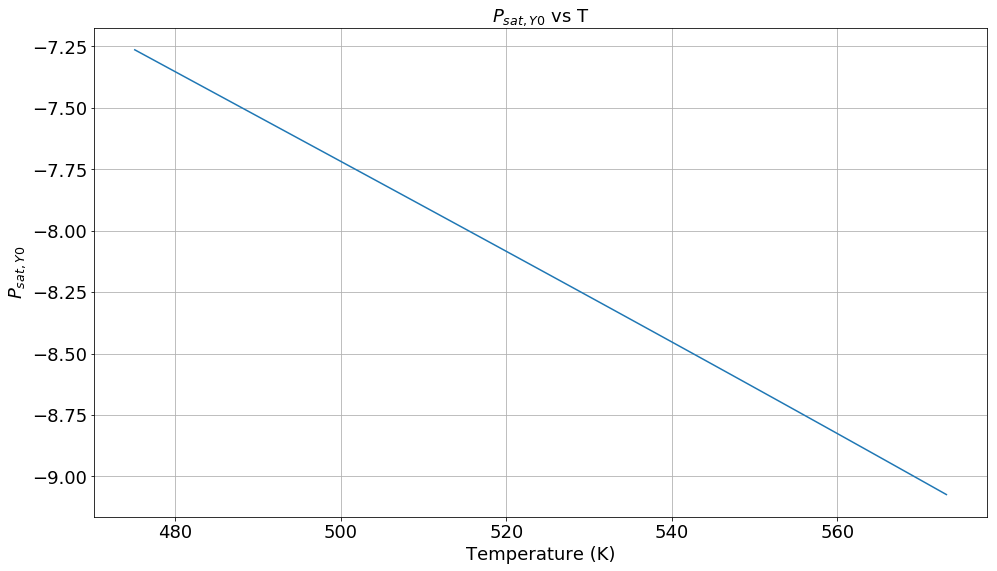

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['P_sat_dY0'])
ax.set_ylabel('$P_{sat,Y0}$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$P_{sat,Y0}$ vs T',fontsize=18)
plt.show()

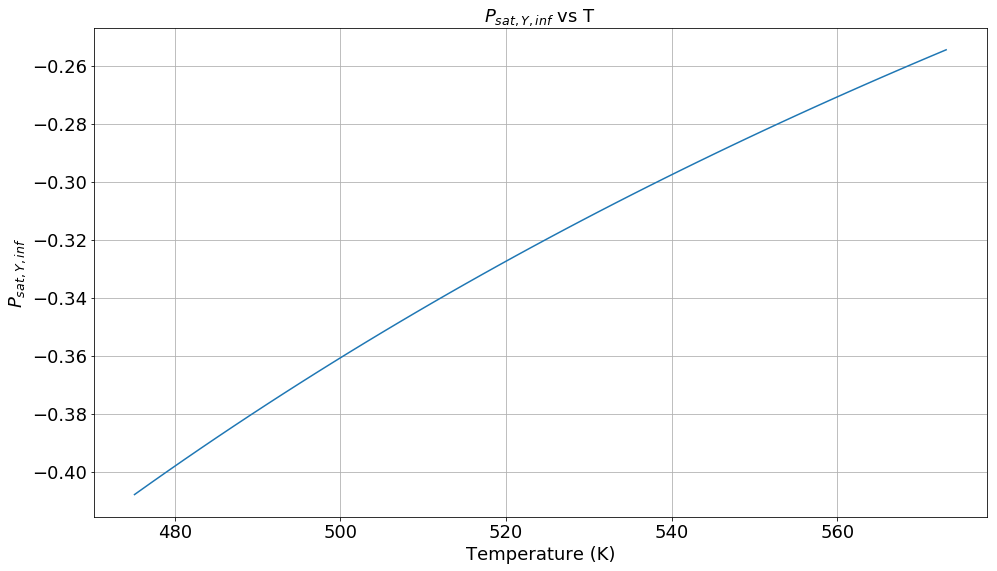

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['P_sat_dY_inf'])
ax.set_ylabel('$P_{sat,Y,inf}$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$P_{sat,Y,inf}$ vs T',fontsize=18)
plt.show()